In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
colors=cm.coolwarm(np.linspace(1, 0, 500)) # red first
import diffmah
from diffmah import mah_halopop, DEFAULT_MAH_PARAMS
import jax
from jax import grad
from jax import random
import jax.numpy as jnp
from jax import vmap 
from tqdm.autonotebook import tqdm

/var/folders/gw/k3g4y13d0_38hyq_g18hp1s80000gn/T/ipykernel_8762/2472127841.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def Psi_logtc(logtc, mu, var):
    return np.exp(-((logtc - mu) ** 2) / (2 * var))

In [3]:
def Psi_early(early, mu, var):
    return np.exp(-((early - mu) ** 2) / (2 * var))

In [4]:
def Psi_late(late, mu, var):
    return np.exp(-((late - mu) ** 2) / (2 * var))

## Arbitrary realization of diffmahpop with $\psi_{MAH}$: {$\psi_{logtc}$, $\psi_{early}$, and $\psi_{late}$}

In [5]:
logtc_mean = jnp.log10(2)
logtc_var = 0.2
logtc = jnp.linspace(jnp.log10(0.5), jnp.log10(8), 100)
logtc_pop = Psi_logtc(logtc, logtc_mean, logtc_var)

keytc = random.PRNGKey(0)
logtc_draws = logtc_mean + jnp.sqrt(logtc_var) * random.normal(keytc, shape=(500,))

In [6]:
early_mean = 3
early_var = 0.5
early = jnp.linspace(0.1, 10, 100)
early_pop = Psi_early(early, early_mean, early_var)

keyearly = random.PRNGKey(1)
early_draws = early_mean + jnp.sqrt(early_var) * random.normal(keyearly, shape=(500,))

In [7]:
late_mean = 2
late_var = 0.2
late = jnp.linspace(0.1, 5, 100)
late_pop = Psi_late(late, late_mean, late_var)

keylate = random.PRNGKey(2)
late_draws = late_mean + jnp.sqrt(late_var) * random.normal(keylate, shape=(500,))

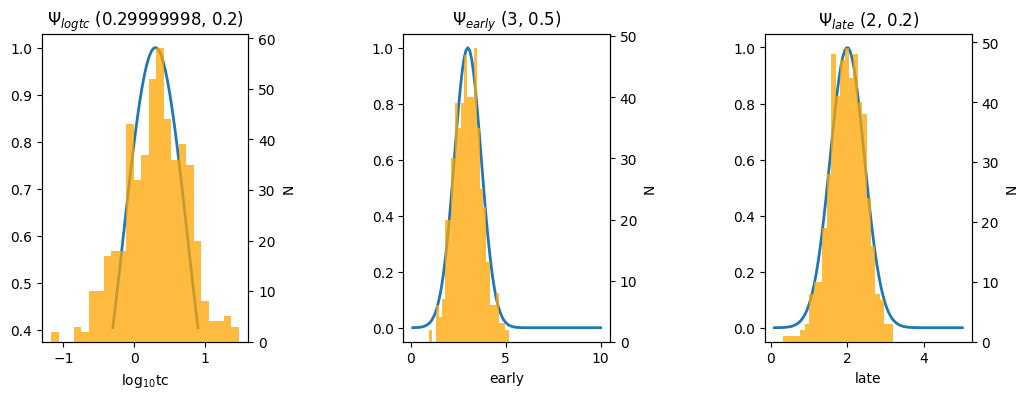

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
fig.subplots_adjust(wspace=0.75)
ax[0].plot(logtc, logtc_pop, lw=2)
ax0_twin = ax[0].twinx()
ax0_twin.hist(logtc_draws, bins=25, alpha=0.75, color='orange')
ax0_twin.set_ylabel('N')
ax[0].set_xlabel('log$_{10}$tc')
ax[0].set_title('\u03a8$_{logtc}$ ('+str(np.round(logtc_mean,2))+', '+str(logtc_var)+')')

ax[1].plot(early, early_pop, lw=2)
ax1_twin = ax[1].twinx()
ax1_twin.hist(early_draws, bins=25, alpha=0.75, color='orange')
ax1_twin.set_ylabel('N')
ax[1].set_xlabel('early')
ax[1].set_title('\u03a8$_{early}$ ('+str(np.round(early_mean,2))+', '+str(early_var)+')')

ax[2].plot(late, late_pop, lw=2)
ax2_twin = ax[2].twinx()
ax2_twin.hist(late_draws, bins=25, alpha=0.75, color='orange')
ax2_twin.set_ylabel('N')
ax[2].set_xlabel('late')
ax[2].set_title('\u03a8$_{late}$ ('+str(np.round(late_mean,2))+', '+str(late_var)+')')
plt.show()

In [9]:
def diffmahpop_model(psi, tarr):

    #varying parameters
    logtc_mean = psi["logtc_mean"]
    logtc_var = psi["logtc_var"]

    logtc_draws = logtc_mean + jnp.sqrt(logtc_var) * random.normal(keytc, shape=(500,))
    
    early_mean = psi["early_mean"]
    early_var = psi["early_var"]
    early_draws = early_mean + jnp.sqrt(early_var) * random.normal(keyearly, shape=(500,))
    
    late_mean = psi["late_mean"]
    late_var = psi["late_var"]
    late_draws = late_mean + jnp.sqrt(late_var) * random.normal(keylate, shape=(500,))

    ZZ = jnp.zeros(len(logtc_draws))
    logt0 = jnp.log10(tarr[-1])
    
    #fixed parameters
    logm0_arr = 13. + ZZ
    t_peak_arr = 14.0 + ZZ

    
    mah_params = DEFAULT_MAH_PARAMS._make((logm0_arr, logtc_draws, early_draws, late_draws, t_peak_arr))
    dmhdt, log_mahs = mah_halopop(mah_params, tarr, logt0)

    return log_mahs, jnp.mean(log_mahs, axis=0)

In [10]:
def mse(mean_mhalo_true: jnp.ndarray, mean_mhalo_pred: jnp.ndarray) -> float:
    """Mean squared error function."""
    return jnp.mean(jnp.power(mean_mhalo_true - mean_mhalo_pred, 2))

In [11]:
def mseloss(psi, model, tarr, mean_mhalo_true):
    _, mean_mhalo_pred = model(psi, tarr)
    return mse(mean_mhalo_true, mean_mhalo_pred)

In [12]:
dmseloss = grad(mseloss)

In [13]:
def model_optimization_loop(psi, model, loss, dloss, tarr, mean_mhalo_true, n_steps=10000, step_size=0.001):
    
    losses = []

    for i in tqdm(range(n_steps)):
        
        grads = dloss(dict(logtc_mean=psi["logtc_mean"], logtc_var=psi["logtc_var"],
                           early_mean=psi["early_mean"], early_var=psi["early_var"], 
                           late_mean=psi["late_mean"], late_var=psi["late_var"]),
                      model, tarr, mean_mhalo_true)
        
        psi["logtc_mean"] = psi["logtc_mean"] - step_size*grads["logtc_mean"]
        psi["logtc_var"]  = psi["logtc_var"]  - step_size*grads["logtc_var"]
        
        psi["early_mean"] = psi["early_mean"] - step_size*grads["early_mean"]
        psi["early_var"]  = psi["early_var"]  - step_size*grads["early_var"]
        
        psi["late_mean"]  = psi["late_mean"]  - step_size*grads["late_mean"]
        psi["late_var"]   = psi["late_var"]   - step_size*grads["late_var"]

        losses.append(loss(dict(logtc_mean=psi["logtc_mean"], logtc_var=psi["logtc_var"],
                           early_mean=psi["early_mean"], early_var=psi["early_var"], 
                           late_mean=psi["late_mean"], late_var=psi["late_var"]), 
                           model, tarr, mean_mhalo_true))

    return losses, psi

#### fiducial model

In [14]:
tarr = jnp.linspace(0.5, 13.8, 100)
log_mahs_true, mean_mhalo_true = diffmahpop_model(dict(logtc_mean=logtc_mean, logtc_var=logtc_var,
                                                       early_mean=early_mean, early_var=early_var, 
                                                       late_mean=late_mean, late_var=late_var), tarr)


#### random initial guess

In [15]:
logtc_mean_rand = np.random.uniform(jnp.log10(1),jnp.log10(3))
logtc_var_rand = np.random.uniform(0.1,0.3)

early_mean_rand = np.random.uniform(0.1,10)
early_var_rand = np.random.uniform(0.05,0.4)

late_mean_rand = np.random.uniform(0.1,5)
late_var_rand = np.random.uniform(0.05,0.4)

# print(f'logtc_rand: {logtc_rand}\nearly_rand: {early_rand}\nlate_rand: {late_rand}')
log_mahs_guess, mean_mhalo_guess = diffmahpop_model(dict(logtc_mean=logtc_mean_rand, logtc_var=logtc_var_rand,
                                                         early_mean=early_mean_rand, early_var=early_var_rand, 
                                                         late_mean=late_mean_rand, late_var=late_var_rand), tarr)


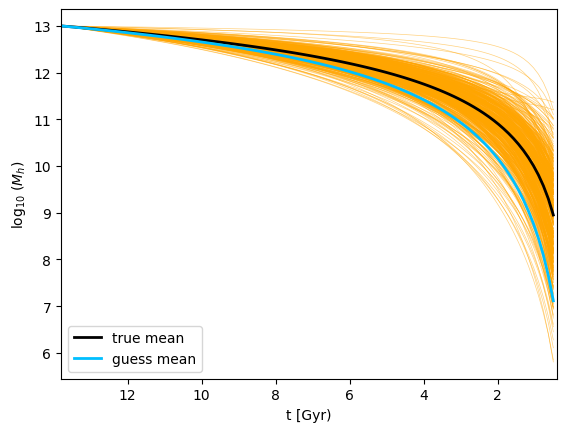

In [16]:
fig, ax = plt.subplots(1, 1)
# __=ax.semilogy()

i=0
for mah in log_mahs_true:
    __=ax.plot(tarr, mah, color='orange', alpha=0.5, lw=0.5)
    i+=1
__=ax.plot(tarr, mean_mhalo_true, c='k', lw=2, label='true mean')
__=ax.plot(tarr, mean_mhalo_guess, c='deepskyblue', lw=2, label='guess mean')



__=ax.set_xlabel('t [Gyr)')
__=ax.set_xlim(0.4,13.8)
__=ax.invert_xaxis()
ax.set_ylabel('log$_{10}$ ($M_{h}$)')
plt.legend()
plt.show()

In [17]:
dmseloss(dict(logtc_mean=logtc_mean_rand, logtc_var=logtc_var_rand,
           early_mean=early_mean_rand, early_var=early_var_rand, 
           late_mean=late_mean_rand, late_var=late_var_rand),
      diffmahpop_model, tarr, mean_mhalo_true)

{'early_mean': Array(0.2951, dtype=float32, weak_type=True),
 'early_var': Array(-0.00307141, dtype=float32, weak_type=True),
 'late_mean': Array(0.17359373, dtype=float32, weak_type=True),
 'late_var': Array(-0.00509543, dtype=float32, weak_type=True),
 'logtc_mean': Array(0.57104796, dtype=float32, weak_type=True),
 'logtc_var': Array(-0.11730634, dtype=float32, weak_type=True)}

In [18]:
losses, psi = model_optimization_loop(dict(logtc_mean=logtc_mean_rand, logtc_var=logtc_var_rand,
                                                         early_mean=early_mean_rand, early_var=early_var_rand, 
                                                         late_mean=late_mean_rand, late_var=late_var_rand),
                                      diffmahpop_model, mseloss, dmseloss, tarr, mean_mhalo_true)

  0%|          | 0/10000 [00:00<?, ?it/s]

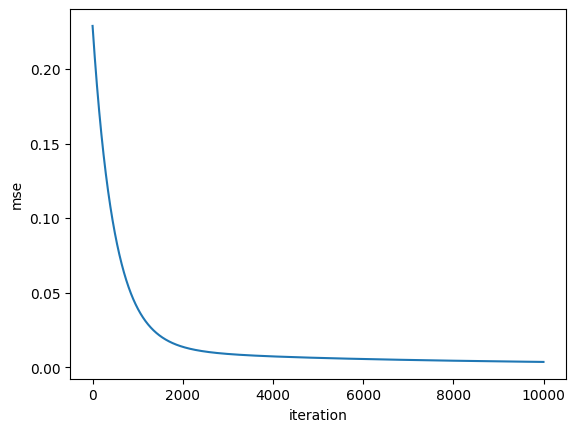

In [19]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('mse')
plt.show()

#### Fitted model

In [20]:
log_mahs_fit, mean_mhalo_fit = diffmahpop_model(dict(logtc_mean=psi["logtc_mean"], logtc_var=psi["logtc_var"],
                                                         early_mean=psi["early_mean"], early_var=psi["early_var"], 
                                                         late_mean=psi["late_mean"], late_var=psi["late_var"]), tarr)

In [21]:
mean_mhalo_fit

Array([ 8.582867 ,  9.060798 ,  9.427673 ,  9.72115  ,  9.963041 ,
       10.167015 , 10.342153 , 10.494759 , 10.629363 , 10.749323 ,
       10.857183 , 10.954907 , 11.0440445, 11.125833 , 11.201272 ,
       11.27119  , 11.336264 , 11.397062 , 11.454062 , 11.507676 ,
       11.55825  , 11.606086 , 11.651441 , 11.694546 , 11.735598 ,
       11.774769 , 11.81222  , 11.848081 , 11.882476 , 11.915516 ,
       11.947299 , 11.977914 , 12.007437 , 12.035943 , 12.063493 ,
       12.09015  , 12.115971 , 12.141001 , 12.165287 , 12.188871 ,
       12.211792 , 12.234085 , 12.255785 , 12.2769165, 12.297513 ,
       12.317601 , 12.337202 , 12.3563385, 12.375034 , 12.393309 ,
       12.411177 , 12.42866  , 12.445772 , 12.462532 , 12.478946 ,
       12.495038 , 12.510815 , 12.526289 , 12.541471 , 12.556375 ,
       12.571007 , 12.585381 , 12.599503 , 12.613381 , 12.627026 ,
       12.640443 , 12.653644 , 12.666632 , 12.679414 , 12.691997 ,
       12.704389 , 12.716591 , 12.728615 , 12.740463 , 12.7521

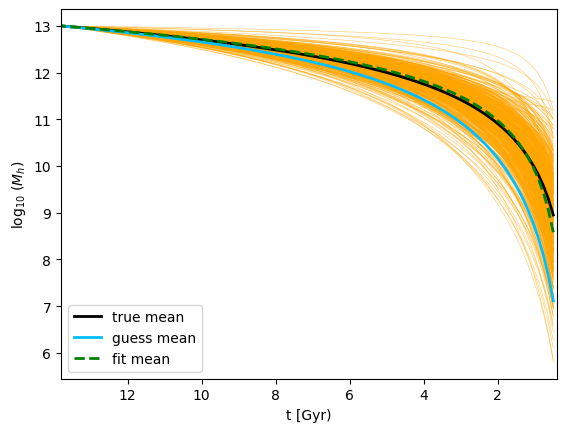

In [22]:
fig, ax = plt.subplots(1, 1)
# __=ax.semilogy()

i=0
for mah in log_mahs_true:
    __=ax.plot(tarr, mah, color='orange', alpha=0.5, lw=0.5)
    i+=1
__=ax.plot(tarr, mean_mhalo_true, c='k', lw=2, label='true mean')
__=ax.plot(tarr, mean_mhalo_guess, c='deepskyblue', lw=2, label='guess mean')
__=ax.plot(tarr, mean_mhalo_fit, c='g', ls ='--', lw=2, label='fit mean')




__=ax.set_xlabel('t [Gyr)')
__=ax.set_xlim(0.4,13.8)
__=ax.invert_xaxis()
ax.set_ylabel('log$_{10}$ ($M_{h}$)')
plt.legend()
plt.show()

## Fit the model with variance in target data: $\sigma$ (log$_{10}$(M$_{h}$(t)))

In [23]:
def diffmahpop_model_w_var(psi, tarr):

    #varying parameters
    logtc_mean = psi["logtc_mean"]
    logtc_var = psi["logtc_var"]

    logtc_draws = logtc_mean + jnp.sqrt(logtc_var) * random.normal(keytc, shape=(500,))
    
    early_mean = psi["early_mean"]
    early_var = psi["early_var"]
    early_draws = early_mean + jnp.sqrt(early_var) * random.normal(keyearly, shape=(500,))
    
    late_mean = psi["late_mean"]
    late_var = psi["late_var"]
    late_draws = late_mean + jnp.sqrt(late_var) * random.normal(keylate, shape=(500,))

    ZZ = jnp.zeros(len(logtc_draws))
    logt0 = jnp.log10(tarr[-1])
    
    #fixed parameters
    logm0_arr = 13. + ZZ
    t_peak_arr = 14.0 + ZZ

    
    mah_params = DEFAULT_MAH_PARAMS._make((logm0_arr, logtc_draws, early_draws, late_draws, t_peak_arr))
    dmhdt, log_mahs = mah_halopop(mah_params, tarr, logt0)

    return log_mahs, jnp.mean(log_mahs, axis=0), jnp.var(log_mahs, axis=0)

In [24]:
def mse(mean_mhalo_true: jnp.ndarray, mean_mhalo_pred: jnp.ndarray,
       var_mhalo_true: jnp.ndarray) -> float:
    """Mean squared error function."""
    return jnp.mean(jnp.power(mean_mhalo_true - mean_mhalo_pred, 2)/var_mhalo_true)

In [25]:
def mseloss(psi, model, tarr, mean_mhalo_true, var_mhalo_true):
    _, mean_mhalo_pred, _ = model(psi, tarr)
    return mse(mean_mhalo_true, mean_mhalo_pred, var_mhalo_true)

In [26]:
dmseloss = grad(mseloss)

In [27]:
def model_optimization_loop(psi, model, loss, dloss, tarr, mean_mhalo_true, var_mhalo_true, 
                            n_steps=10000, step_size=0.001):
    
    losses = []

    for i in tqdm(range(n_steps)):
        
        grads = dloss(dict(logtc_mean=psi["logtc_mean"], logtc_var=psi["logtc_var"],
                           early_mean=psi["early_mean"], early_var=psi["early_var"], 
                           late_mean=psi["late_mean"], late_var=psi["late_var"]),
                      model, tarr, mean_mhalo_true, var_mhalo_true)
        
        psi["logtc_mean"] = psi["logtc_mean"] - step_size*grads["logtc_mean"]
        psi["logtc_var"]  = psi["logtc_var"]  - step_size*grads["logtc_var"]
        
        psi["early_mean"] = psi["early_mean"] - step_size*grads["early_mean"]
        psi["early_var"]  = psi["early_var"]  - step_size*grads["early_var"]
        
        psi["late_mean"]  = psi["late_mean"]  - step_size*grads["late_mean"]
        psi["late_var"]   = psi["late_var"]   - step_size*grads["late_var"]

        losses.append(loss(dict(logtc_mean=psi["logtc_mean"], logtc_var=psi["logtc_var"],
                           early_mean=psi["early_mean"], early_var=psi["early_var"], 
                           late_mean=psi["late_mean"], late_var=psi["late_var"]), 
                           model, tarr, mean_mhalo_true, var_mhalo_true))

    return losses, psi

#### Target data

In [28]:
log_mahs_true, mean_mhalo_true, var_mhalo_true = diffmahpop_model_w_var(dict(logtc_mean=logtc_mean, logtc_var=logtc_var,
                                                                             early_mean=early_mean, early_var=early_var, 
                                                                             late_mean=late_mean, late_var=late_var), tarr)

#### Random initial guess

In [29]:
# logtc_mean_rand = np.random.uniform(jnp.log10(1),jnp.log10(3))
# logtc_var_rand = np.random.uniform(0.1,0.3)

# early_mean_rand = np.random.uniform(0.1,10)
# early_var_rand = np.random.uniform(0.05,0.4)

# late_mean_rand = np.random.uniform(0.1,5)
# late_var_rand = np.random.uniform(0.05,0.4)

# print(f'logtc_rand: {logtc_rand}\nearly_rand: {early_rand}\nlate_rand: {late_rand}')
log_mahs_guess, mean_mhalo_guess, var_mhalo_guess = diffmahpop_model_w_var(dict(logtc_mean=logtc_mean_rand, logtc_var=logtc_var_rand,
                                                               early_mean=early_mean_rand, early_var=early_var_rand, 
                                                               late_mean=late_mean_rand, late_var=late_var_rand), tarr)


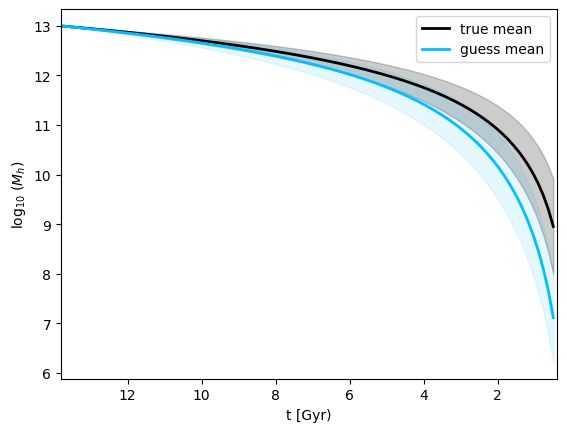

In [30]:
fig, ax = plt.subplots(1, 1)
# __=ax.semilogy()

i=0
for mah in log_mahs_true:
    #__=ax.plot(tarr, mah, color='orange', alpha=0.05, lw=0.5)
    i+=1

#true
__=ax.plot(tarr, mean_mhalo_true, c='k', lw=2, label='true mean')
std_true = np.sqrt(var_mhalo_true)
__=ax.fill_between(tarr, mean_mhalo_true-std_true, mean_mhalo_true+std_true, color='k', alpha=0.2)

#initial guess
__=ax.plot(tarr, mean_mhalo_guess, c='deepskyblue', lw=2, label='guess mean')
std_guess = np.sqrt(var_mhalo_guess)
__=ax.fill_between(tarr, mean_mhalo_guess-std_guess, mean_mhalo_guess+std_guess, color='deepskyblue', alpha=0.1)



__=ax.set_xlabel('t [Gyr)')
__=ax.set_xlim(0.4,13.8)
__=ax.invert_xaxis()
ax.set_ylabel('log$_{10}$ ($M_{h}$)')
plt.legend()
plt.show()

In [31]:
losses, psi = model_optimization_loop(dict(logtc_mean=logtc_mean_rand, logtc_var=logtc_var_rand,
                                                         early_mean=early_mean_rand, early_var=early_var_rand, 
                                                         late_mean=late_mean_rand, late_var=late_var_rand),
                                      diffmahpop_model_w_var, mseloss, dmseloss, tarr, mean_mhalo_true, var_mhalo_true)

  0%|          | 0/10000 [00:00<?, ?it/s]

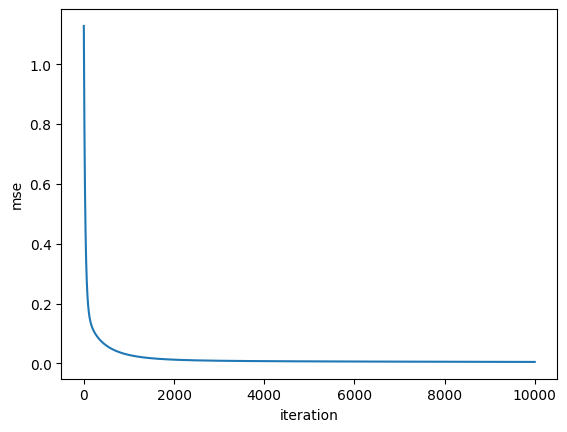

In [32]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('mse')
plt.show()

In [33]:
log_mahs_fit, mean_mhalo_fit, var_mhalo_fit = diffmahpop_model_w_var(dict(logtc_mean=psi["logtc_mean"], logtc_var=psi["logtc_var"],
                                                                          early_mean=psi["early_mean"], early_var=psi["early_var"],
                                                                          late_mean=psi["late_mean"], late_var=psi["late_var"]), tarr)

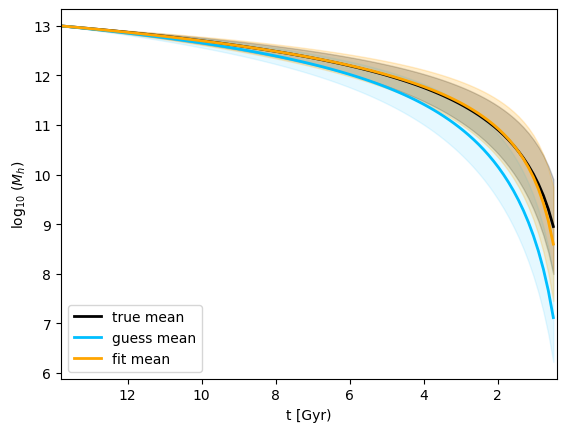

In [34]:
fig, ax = plt.subplots(1, 1)
# __=ax.semilogy()

i=0
for mah in log_mahs_true:
  #  __=ax.plot(tarr, mah, color='orange', alpha=0.05, lw=0.5)
    i+=1

#true
__=ax.plot(tarr, mean_mhalo_true, c='k', lw=2, label='true mean')
std_true = np.sqrt(var_mhalo_true)
__=ax.fill_between(tarr, mean_mhalo_true-std_true, mean_mhalo_true+std_true, color='k', alpha=0.2)

#initial guess
__=ax.plot(tarr, mean_mhalo_guess, c='deepskyblue', lw=2, label='guess mean')
std_guess = np.sqrt(var_mhalo_guess)
__=ax.fill_between(tarr, mean_mhalo_guess-std_guess, mean_mhalo_guess+std_guess, color='deepskyblue', alpha=0.1)

#fit
__=ax.plot(tarr, mean_mhalo_fit, c='orange', lw=2, label='fit mean')
std_fit = np.sqrt(var_mhalo_fit)
__=ax.fill_between(tarr, mean_mhalo_fit-std_fit, mean_mhalo_fit+std_fit, color='orange', alpha=0.2)

__=ax.set_xlabel('t [Gyr)')
__=ax.set_xlim(0.4,13.8)
__=ax.invert_xaxis()
ax.set_ylabel('log$_{10}$ ($M_{h}$)')
plt.legend()
plt.show()